<a href="https://colab.research.google.com/github/MRsources/MRzero-Core/blob/main/documentation/playground_mr0/mr0_GRE_to_FLASH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pypulseq &> /dev/null
!pip install  torchkbnufft --no-deps
!pip install MRzeroCore --no-deps
!pip install pydisseqt
!pip install ismrmrd

(GRE2FLASH_seq)=
# Interactive GRE to FLASH

In [12]:
import numpy as np
import MRzeroCore as mr0
import pypulseq as pp
import torch
import matplotlib.pyplot as plt

# Plot setup
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 100

# Experiment parameters
experiment_id = 'exB05_GRE_to_FLASH'

def seq_gre_to_flash(
    fov = 200e-3,
    slice_thickness = 8e-3,
    sz = (32, 32),
    Nread = 64,
    Nphase = 64,
    FA=10,
    TE_ms=4,
    TR_delay=0,
    P_rfspoil=True,
    rf_spoiling_inc=84,
    P_gspoil=True,
    P_PE=True,
    P_PE_rewinder=True
):

    # %% S1. SETUP SYSTEM OPTIONS
    # Choose the scanner limits
    system = pp.Opts(
        max_grad=28,
        grad_unit='mT/m',
        max_slew=150,
        slew_unit='T/m/s',
        rf_ringdown_time=20e-6,
        rf_dead_time=100e-6,
        adc_dead_time=20e-6,
        grad_raster_time=10e-6
    )

    # %% S2. DEFINE THE SEQUENCE
    # Create a new sequence
    seq = pp.Sequence()

    # Define FOV, resolution, and spin system size
    # fov = 200e-3 # Removed as it is now a parameter
    # slice_thickness = 8e-3 # Removed as it is now a parameter
    # sz = (32, 32)  # Spin system size / resolution # Removed as it is now a parameter
    # Nread = 64     # Frequency encoding steps/samples # Removed as it is now a parameter
    # Nphase = 64    # Phase encoding steps/samples # Removed as it is now a parameter

    TE=TE_ms*1e-3

    # Define RF events
    rf1, gz, gzr = pp.make_sinc_pulse(
        flip_angle=FA * np.pi / 180,
        duration=1e-3,
        slice_thickness=slice_thickness,
        apodization=0.5,
        time_bw_product=4,
        system=system,
        return_gz=True
    )
    dwell=10e-5

    # Define other gradients and ADC events
    gx = pp.make_trapezoid(channel='x', flat_area=Nread / fov, flat_time=Nread*dwell, system=system)

    adc = pp.make_adc(num_samples=Nread, duration=Nread*dwell, phase_offset=0, delay=gx.rise_time, system=system)
    gx_pre = pp.make_trapezoid(channel='x', area=-gx.area / 2, duration=5e-3, system=system)
    gx_spoil = pp.make_trapezoid(channel='x', area=1.5 * gx.area, duration=2e-3, system=system)

    # Calculate delay to match requested TE
    rf_center2end = pp.calc_duration(gz)/2
    adc_center = pp.calc_duration(adc) / 2 + pp.calc_duration(gx_pre)
    TEd = TE - (adc_center - rf_center2end)
    TEd = max(0, TEd)  # Ensure non-negative delay

    TEd=round(TEd/(2*10e-7))*(2*10e-7)

    # Phase encoding configuration
    phenc = np.arange(-Nphase // 2, Nphase // 2) / fov
    permvec = np.arange(0, Nphase)

    # Centric reordering
    permvec = sorted(permvec, key=lambda x: abs(len(phenc) // 2 - x))
    phenc_centr = phenc[permvec] * P_PE

    # Construct the sequence
    for ii in range(Nphase):
        # RF Spoiling
        if P_rfspoil:
            rf_phase = 0.5 * rf_spoiling_inc * (ii**2 + ii + 2)
            rf1.phase_offset = rf_phase / 180 * np.pi
            adc.phase_offset = rf_phase / 180 * np.pi

        # Add RF block
        seq.add_block(rf1,gz)
        seq.add_block(pp.make_delay(TEd))

        # Add gradient prephasing and ADC block
        gp = pp.make_trapezoid(channel='y', area=phenc_centr[ii], duration=5e-3, system=system)
        seq.add_block(gx_pre, gp,gzr)
        seq.add_block(adc, gx)

        # Add gradient spoiling or rewinder
        gp_rewind = pp.make_trapezoid(channel='y', area=-phenc_centr[ii], duration=5e-3, system=system)
        if P_gspoil and P_PE_rewinder:
            seq.add_block(gx_spoil, gp_rewind)
        elif P_gspoil:
            seq.add_block(gx_spoil)
        elif P_PE_rewinder:
            seq.add_block(gp_rewind)

        # Add TR delay if needed
        if ii < Nphase - 1:
            seq.add_block(pp.make_delay(TR_delay))

    # Check whether the timing of the sequence is correct
    ok, error_report = seq.check_timing()
    if ok:
        print('Timing check passed successfully')
    else:
        print('Timing check failed. Error listing follows:')
        for e in error_report:
            print(e, end="")

    # Echo time is defined as the time from RF pulse center to ADC center
    print(f"Calculated Echo Time (TE): {TE * 1e3:.2f} ms")

    seq.set_definition('FOV', [fov, fov, slice_thickness])
    seq.set_definition('Name', 'gre')
    seq.set_definition('permvec', permvec)

    return seq



/tmp/ipython-input-12-1376131392.py:57: UserWarning: Specified RF delay 0.00 us is less than the dead time 100 us. Delay was increased to the dead time.
  rf1, gz, gzr = pp.make_sinc_pulse(
/tmp/ipython-input-12-1376131392.py:71: UserWarning: Specified ADC delay 10.00 us is less than the dead time 20 us. Delay was increased to the dead time.
  adc = pp.make_adc(num_samples=Nread, duration=Nread*dwell, phase_offset=0, delay=gx.rise_time, system=system)


Timing check passed successfully
Calculated Echo Time (TE): 4.00 ms
Timing check passed successfully


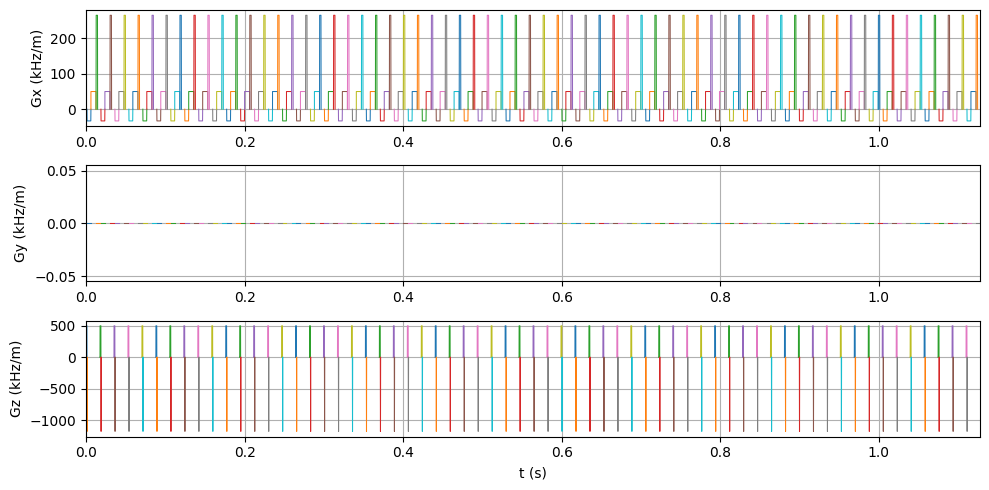

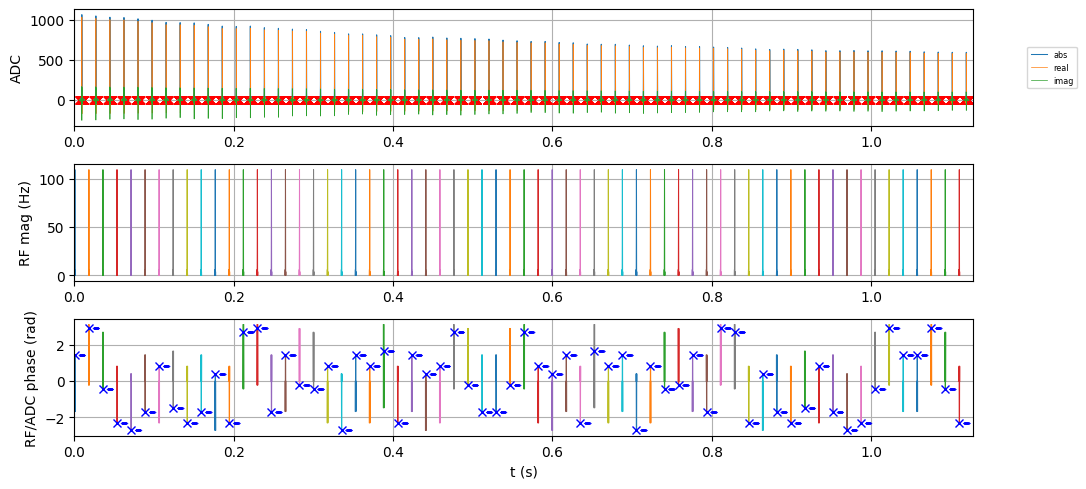

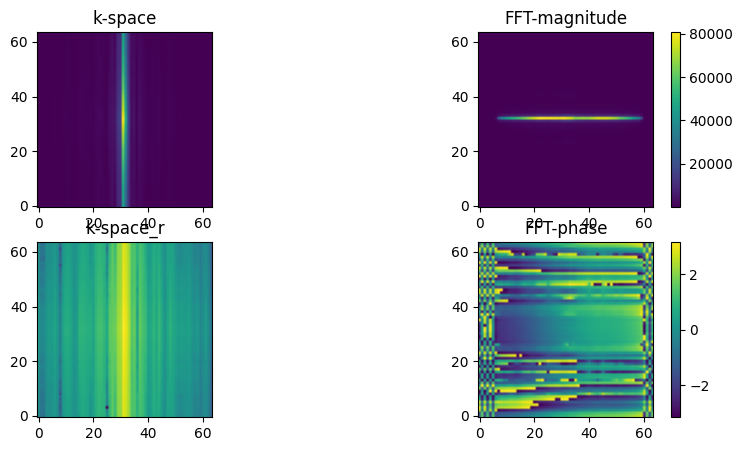

In [16]:
#@title Run sequence
fov = 200e-3 #@param {type:"number"}
slice_thickness = 8e-3 #@param {type:"number"}
sz_x = 32 #@param {type:"integer"}
sz_y = 32 #@param {type:"integer"}
Nread = 64 #@param {type:"integer"}
Nphase = 64 #@param {type:"integer"}
FA=10         #@param {type: "slider", min: 1, max: 90}
TE_ms = 4 #@param {type: "slider", min: 1, max: 100}
TR_delay=0   #@param {type: "number"}
P_rfspoil=True #@param {type: "boolean"}
rf_spoiling_inc = 84 #@param {type: "slider", min: 0, max: 180}
P_gspoil=True  #@param {type: "boolean"}

P_PE=True #@param {type: "boolean"}
P_PE_rewinder=True #@param {type: "boolean"}


seq = seq_gre_to_flash(fov = fov, slice_thickness = slice_thickness,
    sz = (sz_x, sz_y),Nread = Nread,Nphase = Nphase,FA=FA,TE_ms=TE_ms,
    TR_delay=TR_delay, P_rfspoil=P_rfspoil, rf_spoiling_inc=rf_spoiling_inc,
    P_gspoil=P_gspoil, P_PE=P_PE, P_PE_rewinder=P_PE_rewinder)


# Check whether the timing of the sequence is correct
ok, error_report = seq.check_timing()
if ok:
    print('Timing check passed successfully')
else:
    print('Timing check failed. Error listing follows:')
    for e in error_report:
        print(e, end="")

#%% S3: quick 2D brain phantom sim and plot
signal,_= mr0.util.simulate(seq)
#seq.plot(plot_now=False,time_range=(0,2.5*TE))
seq.plot(plot_now=False)
mr0.util.insert_signal_plot(seq=seq, signal =signal.numpy())
plt.show()

permvec=seq.get_definition('permvec')
# %% S4: MR IMAGE RECON of signal ::: #####################################
kspace = torch.reshape((signal), (Nphase, Nread)).clone().t()
ipermvec = np.argsort(permvec)
kspace=kspace[:,ipermvec]

# # fftshift,FFT,fftshift
spectrum = torch.fft.fftshift(kspace)
space = torch.fft.fft2(spectrum)
space = torch.fft.ifftshift(space)

plt.subplot(221)
plt.title('k-space')
mr0.util.imshow(np.abs(kspace.numpy()))
plt.subplot(223)
plt.title('k-space_r')
mr0.util.imshow(np.log(np.abs(kspace.numpy())))

plt.subplot(222)
plt.title('FFT-magnitude')
mr0.util.imshow(np.abs(space.numpy()))
plt.colorbar()
plt.subplot(224)
plt.title('FFT-phase')
mr0.util.imshow(np.angle(space.numpy()), vmin=-np.pi, vmax=np.pi)
plt.colorbar()

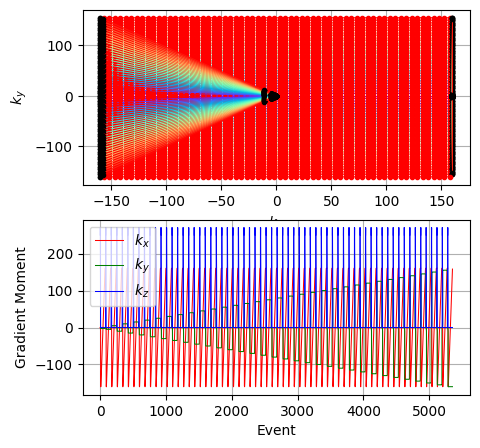

In [15]:
#@title S5. WRITE the sequence  as .seq
# Check whether the timing of the sequence is correct

# Prepare the sequence output for the scanner
seq.set_definition('FOV', [fov, fov, slice_thickness])
seq.set_definition('Name', 'gre')
seq.write(experiment_id + '.seq')


seq0 = mr0.Sequence.import_file(experiment_id + '.seq')
seq0.plot_kspace_trajectory()